# How Does Piyush's Model Do as Classifier?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [4]:
inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [5]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [6]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

In [7]:
import tensorflow as tf

gpu_list = ["/gpu:0","/gpu:1"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

Number of devices: 2


In [8]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [9]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16), layers=['EMB2', 'EMB3']),last=True)

In [10]:
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (128, 4), layers=['EMB1']),last=True)

In [11]:
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [12]:
def merged_model(droprate=.5):
    with strategy.scope():
        # EMB1 image (convolutional)
        input1 = Input(shape=(128,4,1), name='emb1_input')
        x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_1')(input1)
        x1 = Activation('relu')(x1)
        # x1 = Dropout(droprate)(x1)
        x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_2')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_3')(x1)
        x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_3')(x1)
        x1 = Activation('relu')(x1)
        #x1 = Dropout(droprate)(x1)
        x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_4')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_5')(x1)
        x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_6')(x1)
        x1 = Activation('relu')(x1)
        x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_7')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_8')(x1)
        x1 = Dropout(droprate, name='emb1_dropout_4')(x1)
        x1 = Flatten(name='emb1_flatten_9')(x1)
        x1 = Dense(128, activation='relu', name='emb1_dense_9')(x1)

        # EMB23 image (convolutional)
        input2 = Input(shape=(16,16,2), name='emb23_input')
        x2 = Convolution2D(32, (1, 1), padding='same', name='emb23_conv1d_1')(input2)
        x2 = Activation('relu')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = Convolution2D(64, (2, 2), padding='same', name='emb23_conv2d_2')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_3')(x2)
        x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_4')(x2)
        x2 = Activation('relu')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_5')(x2)
        x2 = Activation('relu')(x2)
        x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_6')(x2)
        x2 = Dropout(droprate, name='emb23_dropout_4')(x2)
        x2 = Flatten(name='emb23_flatten_7')(x2)
        x2 = Dense(128, activation='relu', name='emb23_dense_8')(x2)

        # tiles image (convolutional)
        input3 = Input(shape=(4,4,3), name='tiles_input')
        x3 = Convolution2D(32, (1, 1), padding='same', name='tiles_conv1d_1')(input3)
        x3 = Activation('relu')(x3)
        # x3 = Dropout(droprate)(x3)
        x3 = Convolution2D(64, (2, 2), padding='same', name='tiles_conv2d_2')(x3)
        x3 = Activation('relu')(x3)
        # x3 = Dropout(droprate)(x3)
        x3 = Convolution2D(128, (2, 2), padding='same', name='tiles_conv2d_3')(x3)
        x3 = Activation('relu')(x3)
        x3 = MaxPool2D(pool_size=(2, 2), padding='same', name='tiles_maxpool_4')(x3)
        x3 = Dropout(droprate, name='tiles_dropout_4')(x3)
        x3 = Flatten(name='tiles_flatten_5')(x3)
        x3 = Dense(128, activation='relu', name='tiles_dense_6')(x3)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2, x3], name='concatenate') 
        x = Dropout(droprate, name='concate_dropout_5')(x)
        x = Dense(64, name='concated_dense_1')(x)    
        x = Activation('relu')(x)
        x = Dropout(droprate, name='dense_dropout_6')(x)

        # final output
        output = Dense(2, activation='softmax', name='dense_output')(x)
        # output = 5*tf.math.tanh(x)   # 0 to +5 range

        model = Model(inputs = [input1, input2, input3], outputs = [output])

        # compile model
        # model = multi_gpu_model(model, gpus=4)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [13]:
model_p1_d02 = merged_model(0.2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [14]:
history_p1_d02 = model_p1_d02.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs=250,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

cy: 0.9505
Epoch 69/250
489899/489899 - 35s - loss: 0.1267 - accuracy: 0.9539 - val_loss: 0.1447 - val_accuracy: 0.9508
Epoch 70/250
489899/489899 - 35s - loss: 0.1261 - accuracy: 0.9536 - val_loss: 0.1445 - val_accuracy: 0.9500
Epoch 71/250
489899/489899 - 35s - loss: 0.1253 - accuracy: 0.9543 - val_loss: 0.1473 - val_accuracy: 0.9506
Epoch 72/250
489899/489899 - 35s - loss: 0.1250 - accuracy: 0.9542 - val_loss: 0.1441 - val_accuracy: 0.9514
Epoch 73/250
489899/489899 - 35s - loss: 0.1243 - accuracy: 0.9543 - val_loss: 0.1442 - val_accuracy: 0.9506
Epoch 74/250
489899/489899 - 35s - loss: 0.1239 - accuracy: 0.9548 - val_loss: 0.1447 - val_accuracy: 0.9515
Epoch 75/250
489899/489899 - 35s - loss: 0.1233 - accuracy: 0.9549 - val_loss: 0.1458 - val_accuracy: 0.9507
Epoch 76/250
489899/489899 - 35s - loss: 0.1230 - accuracy: 0.9551 - val_loss: 0.1468 - val_accuracy: 0.9514
Epoch 77/250
489899/489899 - 35s - loss: 0.1232 - accuracy: 0.9551 - val_loss: 0.1439 - val_accuracy: 0.9514
Epoch 78

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


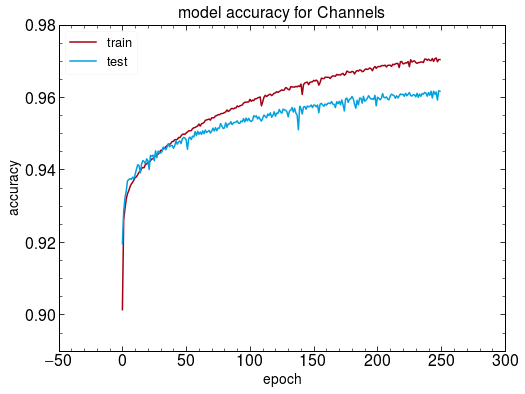

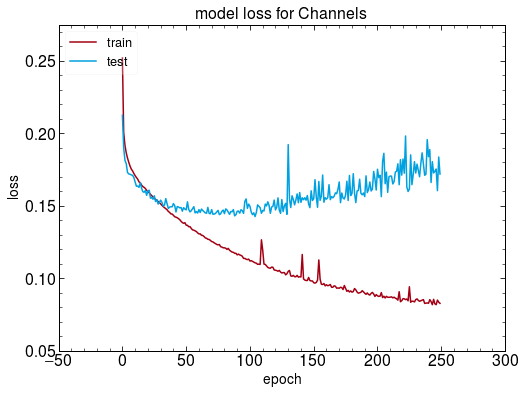

In [17]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_p1_d02.history['accuracy'])
plt.plot(history_p1_d02.history['val_accuracy'])
plt.title('model accuracy for Channels')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_p1_d02.history['loss'])
plt.plot(history_p1_d02.history['val_loss'])
plt.title('model loss for Channels')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

In [18]:
model_p1_d02.save(modelpath+'model_p1_d02.h5')
scores_p1_d02 = model_p1_d02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [19]:
model_p1_d02.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb1_input (InputLayer)         [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
emb1_conv2d_1 (Conv2D)          (None, 128, 4, 32)   320         emb1_input[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 4, 32)   0           emb1_conv2d_1[0][0]              
__________________________________________________________________________________________________
emb1_conv2d_2 (Conv2D)          (None, 128, 4, 32)   9248        activation[0][0]                 
______________________________________________________________________________________________

In [20]:
from sklearn.metrics import roc_curve, auc
roc_fpr_p1_d02, roc_tpr_p1_d02, roc_thresh_p1_d02 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_p1_d02[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_p1_d02 = auc(roc_fpr_p1_d02, roc_tpr_p1_d02)
print('Area under curve for CNN p1_d02 ' + str(roc_auc_p1_d02))

Area under curve for CNN p1_d02 0.9898192961620463


## Best yet!!!